In [5]:
import pandas as pd
#import time
#import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy.random as rnd
import scipy.stats as stats

import networkx as nx
from networkx.algorithms import bipartite

In [6]:
class Stakers: 
    
    def __init__(self, num_stakers, num_nodes_cou, num_nodes_com): 
        #Initialise balances
        self.num_stakers=num_stakers
        
        self.agents_staker=list(range(self.num_stakers)) 
        
        self.balance_stakers_intial_weight=np.random.pareto(1.16, self.num_stakers) #intial balance follows the power-law distribution
        self.sum_balance_stakers_intial_weight = sum(self.balance_stakers_intial_weight)
        self.balance_stakers_intial = [ 2e10 * self.balance_stakers_intial_weight[s]/self.sum_balance_stakers_intial_weight for s in range(self.num_stakers)]
        
        self.balance_stakers_account=dict(zip(self.agents_staker,self.balance_stakers_intial))
        
        self.num_nodes=num_nodes_cou + num_nodes_com
        self.agents_node=list(range(10000, 10000+self.num_nodes))
        
    def network_stakes(self, nodes_util, num_staking_nodes=1): #staker choose num_staking_nodes node each time, default =1 
        #stakers make a decision on whom they want to stake based on the pl_histrory                   
        
        sum_ul = sum(list(nodes_util.values()))   
        p_node_staked = [ nodes_util[u]/sum_ul for u in nodes_util.keys()]
        
        self.staking_network=nx.Graph()
        self.staking_network.add_nodes_from(self.agents_staker, bipartite=0)
        self.staking_network.add_nodes_from(self.agents_node, bipartite=1)
        
        gamma = 0.2 #stakers stake out gamma of all their balance
        
        for staker in self.agents_staker: 
            #staker_to_node=np.random.choice(self.agents_node, int(num_staking_nodes), replace=False)  
            staker_to_node = rnd.choice(self.agents_node, num_staking_nodes, p= p_node_staked, replace=False)
            
            for node in staker_to_node:
                self.staking_network.add_weighted_edges_from([(staker, node, gamma*self.balance_stakers_account[staker])]) 
                
        
        return self.staking_network
    
    def update_balance_stakers(self, rj, bij): 
        user = list(bij.keys())
        for staker in self.agents_staker:
            self.balance_stakers_account[staker] += rj[staker]     
            if staker in user:
                self.balance_stakers_account[staker] += bij[staker]

In [7]:
class Nodes:
    def __init__(self, num_stakers, num_nodes_cou, num_nodes_com, rate_user_cou, rate_user_com):
        #Initialise balances
        
        self.num_nodes=num_nodes_cou + num_nodes_com
        self.num_nodes_cou=num_nodes_cou
        self.num_nodes_com=num_nodes_com
        self.num_stakers=num_stakers
        
        
        self.agents_node=list(range(10000, 10000+self.num_nodes)) 
        self.balance_nodes_intial = np.random.pareto(1.16, self.num_nodes) #intial balance follows the power-law distribution

        self.balance_nodes_account=dict(zip(self.agents_node, self.balance_nodes_intial))
        
        rate_Cn = rate_user_cou
        rate_cn = rate_user_com
        #rate_Jacc = jaccard
        #self.num_user = self.num_nodes_cou + int(0.5 * self.num_nodes_com)
        
        self.num_user_cou = round(rate_Cn * self.num_nodes_cou)
        self.num_user_com = round(rate_cn * self.num_nodes_com)
        self.num_user = self.num_user_cou + self.num_user_com
        self.agents_user = list(range(10000, 10000+self.num_user_cou)) + list(range(10000+self.num_nodes_cou, 10000+self.num_nodes_cou+self.num_user_com))
        self.num_user_len = len(self.agents_user)
        
        self.quality_node_list = np.random.uniform(0, 1, self.num_nodes) # follows U~(0,1)
        self.quality_node = dict(zip(self.agents_node, self.quality_node_list))
        
        self.parti_threshold = 0.8 ## could adjust
        self.parti_level_history = {}
        self.utility_nodes = {}
        for node in self.agents_node: 
            node_pl = self.generate_pl(self.quality_node[node])
            self.parti_level_history[node] =  [node_pl]  
            
            self.utility_nodes[node] = node_pl
            
        #self.parti_level_history= dict(zip(self.agents_node, [[1]]*len(self.agents_node))) #initial particitation level: pl_max=1

        self.reward_rate_history = dict(zip(self.agents_node, [[1]]*len(self.agents_node)))
        
        self.N = 2.0 * self.num_nodes_cou + self.num_nodes_com
        
        ##self.N = 1.0 * self.num_nodes_cou + self.num_nodes_com #cou =com
        
        self.Total_edge_staked = 0
        
    def generate_pl(self, qi, fa=0.95):
        pl = 1
        while qi < rnd.random():
            pl =pl * fa
        return pl
    
    def memory_exp (self, record_hist, total_t = 30):
        lamda = 1.7 #sum of 30days weight ~1
        record_hist = record_hist[-total_t:]
        total_t = len(record_hist)
        
        record_memory_sum = 0
        for t in range(total_t): ## exponential memory function to sum the history 
            record_memory_sum +=  math.exp(-lamda*(total_t-t)) * record_hist[t]
         
        return record_memory_sum   
    
    def update_status(self, s_n_network):
        # calculate total staked from staker             
        
        self.edge_staking = {}
        self.staker_stake = {}
        self.voting_share = {}
        self.voting_weight = {}
        
        self.node_stakers_network=s_n_network
        
        top_nodes = {n for n, d in self.node_stakers_network.nodes(data=True) if d["bipartite"] == 0}
        bottom_nodes = set(self.node_stakers_network) - top_nodes
        degS, degN = bipartite.degrees(self.node_stakers_network, bottom_nodes, weight='weight' )
        self.edge_staking=dict(degN)
        self.staker_stake=dict(degS)
        
        self.Total_edge_staked = sum(self.edge_staking.values())       
        
        #self.Cap_max_1 = (1/3) * self.Total_edge_staked
        #self.Cap_max_1 =  5e10 / (self.N)
        
        self.Cap_max_1 = self.Total_edge_staked / self.N  
        self.Low_min_1 = self.Cap_max_1 / 4.0  #the lower bound is 1/4 of the Max cap
        
        #self.Low_min = (1/1000) * self.Total_edge_staked 
        print('total staking:', self.Total_edge_staked)
                
            
        ### update participant level & reward rate => utility score | scaled stake max&min
        self.node_total_stake = self.edge_staking.copy()
        self.Valid_total_edge_staked = self.Total_edge_staked  
        
        for node in self.agents_node: 
            
            parti_level_t = self.generate_pl(self.quality_node[node])
         
            n_pl_t = self.parti_level_history[node].copy()
            n_pl_t.append(parti_level_t)      
            self.parti_level_history[node] = n_pl_t
            
            
            if node < 10000 + self.num_nodes_cou:
                node_type = "Council"
                self.Cap_max = 2 * self.Cap_max_1
                #self.Cap_max = self.Cap_max_1 #cou =com
                
                self.Low_min = self.Low_min_1
                                 
                
            else:
                node_type = "Community"
                self.Cap_max = self.Cap_max_1
                self.Low_min = self.Low_min_1
                
                
            if self.edge_staking[node] > self.Cap_max:
                self.Valid_total_edge_staked -= self.edge_staking[node]- self.Cap_max
                #print(node_type, node, "reach Cap_max", self.edge_staking[node])
                self.edge_staking[node] = self.Cap_max 
                reward_rate_t = self.Cap_max/self.node_total_stake[node]

            elif self.edge_staking[node] < self.Low_min:
                self.Valid_total_edge_staked -= self.edge_staking[node]
                #print(node_type, node, "under Low_min", self.edge_staking[node] )
                self.edge_staking[node] = 0     
                reward_rate_t = 0

            else:
                reward_rate_t =1
            
            n_rr_t_1 = self.reward_rate_history[node].copy()
            n_rr_t_1.append(reward_rate_t)
            self.reward_rate_history[node] = n_rr_t_1
            
            
            if node_type == 'Council':  
                self.Cap_max = 2 * self.Cap_max_1 
                #self.Cap_max = self.Cap_max_1  #cou =com
                self.voting_share[node] = min(self.node_total_stake[node], self.Cap_max)* self.N / self.Valid_total_edge_staked
                
                #self.voting_weight[node] = round(self.voting_share[node]) #cou =com
                
                
                if self.voting_share[node] > 1.5:
                    self.voting_weight[node] = 2
                else:
                    self.voting_weight[node] = 1  
            
            if node_type == "Community":
                self.Cap_max = self.Cap_max_1
                
                self.voting_share[node] = min(self.node_total_stake[node], self.Cap_max)* self.N / self.Valid_total_edge_staked
                
                #self.voting_weight[node] = round(self.voting_share[node]) #cou =com
                
                if self.voting_share[node] > 0.75:
                    self.voting_weight[node] = 1
                else:
                    self.voting_weight[node] = 0.5 
           
        
            ##cou = com & scale weight to [1,2]    
            #if self.voting_share[node] > 1:
             #   self.voting_weight[node] = 2
            #else:
              #  self.voting_weight[node] = 1 

                    
        self.utility_nodes = {}
        
        epsilon = dict(zip(self.agents_node, rnd.uniform(0, 0.1, self.num_nodes))) 
        
        beta_pl = 0.6 #weight of participant level
        beta_rr = 0.3 #weight of reward rate
        
        for node in self.agents_node:
            pl_hist = self.parti_level_history[node]
            rr_hist = self.reward_rate_history[node]
            
            pl_nodes_memory = self.memory_exp(pl_hist)
            rr_nodes_memory = self.memory_exp(rr_hist)
            
        
            score_node_t = beta_pl*pl_nodes_memory + beta_rr*rr_nodes_memory + epsilon[node]
            
            self.utility_nodes[node] = score_node_t            
           
        
    def distribute_rewards(self, rn, rs):
        #balances get updated based on the rewards        

        self.reward_distribute_node = {}
        self.reward_distribute_staker={}
        
        for node in self.agents_node: 
            if self.parti_level_history[node][-1]> self.parti_threshold:         
                pl=1
            else:
                #print(node, "under pl_threshold")
                pl=0
            self.reward_distribute_node[node] = rn * pl * (self.edge_staking[node]/self.Valid_total_edge_staked) # no scaling on total stake of all nodes                                                      
            self.balance_nodes_account[node] += self.reward_distribute_node[node] 
   
            stakerj_i = list(self.node_stakers_network.edges(node))
            
             
            for eachj in range(len(stakerj_i)):
                staker_j = stakerj_i[eachj][1]
                self.reward_distribute_staker[staker_j]= rs * pl * (self.staker_stake[staker_j]/self.node_total_stake[node])* (self.edge_staking[node]/self.Valid_total_edge_staked)
                #Stakers(40,10).balance_stakers_account[staker_j] += self.reward_distribute_staker[staker_j]
        return self.reward_distribute_staker      
    
    
    def user_balance_transfer(self):
        self.node_to_staker = {}
        
        
        for node in self.agents_user: #if the node is a user(node + staker account), he will put all the reward from node account to staker account
            #print(node)
            node_to_staker = node - 10000
            #print('ij', node_to_staker)
            self.node_to_staker[node_to_staker] = self.balance_nodes_account[node]
            self.balance_nodes_account[node] = 0
        return self.node_to_staker
            

In [45]:
class HBar:
    
    def __init__(self, type_reward, ta0, ra0, alpha, beta, epsilon, parameter_l):
        # This function initialises the system of rewards and treasury
        self.alpha = alpha
        self.beta = beta    
        
        self.treasury = ta0
        self.reward = ra0
        self.epsilon = epsilon

        self.type_payout = type_reward
        #self.growth_rate_1 = reward_growth_1
        
        self.parameter_l = parameter_l ## ? when treasure transfer to reward
        
        self.time = 0 
        
        self.time_topup =[]
        
    def iterate(self):
        # This function is called each time-step to update the internal variables of the system
        print('time:', self.time)
        
        #self.transaction_fees = Tx_fee(self.time).calculate_sum_fee()   
        self.transaction_fees = Tx_fee(self.time).Fu_Daily_Tx_fee
        
        # Equation 1
        self.flow_fees_to_treasury = self.alpha * self.transaction_fees
        
        # Equation 4
        self.flow_fees_to_reward = (1-self.alpha) * self.transaction_fees

        
        # Equation 2
        if rnd.random() < self.parameter_l: 
            self.flow_treasury_to_reward = rnd.uniform(0,self.treasury+self.flow_fees_to_treasury)
        else:
            self.flow_treasury_to_reward = 0
        
        
        # Equation 3
        self.treasury += self.flow_fees_to_treasury - self.flow_treasury_to_reward 

        # Equation 5
        self.reward += self.flow_fees_to_reward + self.flow_treasury_to_reward 
        
        
        # The following computes the total daily payout at time t
        reward_t = Daily_payout(self.type_payout, self.time).payout_schedule()
        
        if (reward_t <= self.reward):
            self.reward -= reward_t - self.epsilon
        else:
            # Money is not sufficient in the reward account
            print("FAIL", self.time)
            self.time_topup.append(self.time)
            #Triggers top-up
            self.topup = top_up()
      
            self.reward += self.topup.flow_fund_to_reward
        
        
        # From equation 11
        self.reward_to_stakers    = (1-self.beta) * (reward_t - self.epsilon)
        
        self.reward_to_nodes = self.beta * (reward_t - self.epsilon)
        
        
        self.time += 1
    

In [47]:
class Daily_payout:
    def __init__(self, plan_type, t):
        
        self.type_payout = plan_type
        self.t = t
        
#         self.growth_rate = growth_rate_1
#         if self.growth_rate ==0.1: #m=50 ~ 10% growth rate in 1st year; 
#             self.param_reward_m_de = 50
#             self.param_reward_m_in = 50
#         elif self.growth_rate ==0.48: #m_de=14, m_in=8 ~50% growth rate in 1st 
#             self.param_reward_m_de = 8
#             self.param_reward_m_in = 14
        
        year = int(self.t/365)

#         if self.type_payout == 'constant':
#             self.planned_reward_year = 2.5e6  
        
#         elif self.type_payout == 'decreasing':
#             self.planned_reward_year = Total_reward_year_de[year]
            
#         elif self.type_payout == 'increasing':     
#             self.planned_reward_year = Total_reward_year_in[year]  
#         else:
#             self.planned_reward_year = 1e9    
        
        self.planned_reward_year = Year_total_reward(self.type_payout, year)
    
#         self.sum_dec_a = 0
#         self.sum_inc_b = 0
#         for t in range(1,366):
#             self.sum_dec_a += pow(t, -1/self.param_reward_m_de)
#             self.sum_inc_b += pow(t, 1/self.param_reward_m_in)
    
    def payout_schedule(self):
#         if self.type_payout == 'constant':
#             self.param_reward_c = self.planned_reward_year/365
#             daily_payout = self.param_reward_c
        
#         if self.type_payout == 'decreasing':
#             self.param_reward_a = self.planned_reward_year/self.sum_dec_a
#             daily_payout = self.param_reward_a * pow(self.t, -1/self.param_reward_m_de)
        
#         if self.type_payout == 'increasing':
#             self.param_reward_b = self.planned_reward_year/self.sum_inc_b
#             daily_payout = self.param_reward_b * pow(self.t, 1/self.param_reward_m_in)
        
        daily_payout = self.planned_reward_year/365
        return daily_payout

In [10]:
class Tx_fee:
    
    def __init__(self, t): ##? fixed Tx_fee &dollor further discuss the parameter
        
        self.prp0 = 0.3530936
        
        self.prp1 = 6.03011884
        
        self.t = t
        
        day_pass = 1022 #after age: 1022 days -> 30. June 2022 
        
        self.Fu_Daily_Tx_fee = np.exp(self.prp0 * np.log(self.t+1 +day_pass) + self.prp1 )

### pervious version based on the bass model 

        #self.sum_fee = np.exp(self.prp0 * np.log(t+1 +day_pass) + self.prp1 )
        
#        self.lamabd = 0.99 #99% hbar Tx 1% token Tx
        
#        self.tx_u = 10000
        
#        self.t = 32 + t/(365/12)
        
#         #self.t = t/(365/12)
        
#         self.ex_rate_US_Hbar = 10
        
#         #self.fee_tx=0.0001 * ex_rate_doll_hab
        
#         self.fee_tx_hbar=0.0001 * self.ex_rate_US_Hbar
        
#         self.fee_tx_token = 0.001 * self.ex_rate_US_Hbar
        
     
#         self.num_u = self.Bass_user_growth(self.t)
        
#     def Bass_user_growth(self, t):
        
#         prp=0.0004
#         prq=0.1
    
#         Uo= 1e7 #10 million total potential population 
        
#         cum_u= Uo * (1 - math.exp(-(prp+prq)*t))/(1 + ((prq/prp) * math.exp(-(prp+prq)*t))) 
    
#         return cum_u

    
#     def calculate_sum_fee(self, t): 
#         #self.sum_fee = self.fee_tx * 0.01*self.num_u * self.tx_u
        
#         #self.sum_fee = 0.01 * self.num_u * self.tx_u * (self.lamabd * self.fee_tx_hbar + (1-self.lamabd) * self.fee_tx_token)
        
#         self.sum_fee = 0.3530936 * np.log(t+1) + 6.03011884 

#         return np.exp(self.sum_fee)

In [39]:
def Year_total_reward(type_payout, year):
# Yearly total reward under different reward function based on the log-log fitting of the Tx fee
    
    Day_Tx_fee = []
    Total_fee_year = {}

    for day in range(0, 365*20, 1):
        #print(day)
        Fee = Tx_fee(day).Fu_Daily_Tx_fee
        Day_Tx_fee.append(Fee)

    for each_year in range(1,11,1):
        Total_fee_year[each_year] = sum(Day_Tx_fee[365*(each_year-1): 365*each_year])
    
    Total_reward_year_in = list(Total_fee_year.values())
    Total_reward_year_de = Total_reward_year_in[: :-1]    
    print(Total_reward_year_de[0])
    
    if type_payout == 'constant':
        return 2.5e6
    elif type_payout == 'decreasing':
        return Total_reward_year_de[year]     
    elif type_payout == 'increasing':
        return Total_reward_year_in[year] 
    else: 
        return 1e9
   

In [20]:
class top_up: ##？ further design the top_up 
    def __init__(self, topup=2.5e8): # once topup 250M
        
        self.flow_fund_to_reward = topup


In [57]:
class HederaSystem():
    def __init__(self):        
        
        # type_reward: type of the payout schedule='increasing','decreasing','constant'
        # ta0/ra0: initial balance of treasury/reward account
        # alpha:   proportion Tx fee flow to treasury
        # beta:    proportion Reward account to nodes
        # epsilon: amount of habr as buffer of reward account
        # parameter_l: probability that treasury account to reward account
        
        self.hbar = HBar(type_reward='constant', ta0=0, ra0=2.5e8,  alpha=0.01, beta=0.5, epsilon=0.0, parameter_l=0.0)# add all parameters.
        
        num_node_cou = 39
        num_node_com = 38  #council 39 + community 38
        num_staker = 5 * (num_node_cou+num_node_com)
        
        rate_user_cou=0.5
        rate_user_com=0.5
        
        self.stakers = Stakers(num_staker, num_node_cou, num_node_com) 

        self.nodes = Nodes(num_staker, num_node_cou, num_node_com, rate_user_cou, rate_user_com) 
        
        
    def iterate(self):        
            
        self.S_N_network=self.stakers.network_stakes(self.nodes.utility_nodes, num_staking_nodes=1) #each staker only select one node
        
        self.nodes.update_status(self.S_N_network)
        
        self.hbar.iterate()

        self.rj = self.nodes.distribute_rewards ( self.hbar.reward_to_nodes, self.hbar.reward_to_stakers )
        
        self.rij = self.nodes.user_balance_transfer()
        
        self.stakers.update_balance_stakers(self.rj, self.rij)

        

In [58]:
T = HederaSystem()

Stakers_Balance_t = {}
Nodes_Balance_t = {}

User_Balance_t = {}
Pure_stakers_balance_t = {}
Pure_nodes_balance_t = {}

Reward_Account_t = []
Treasury_Account_t = []

Nodes_voting_weight = {}
Nodes_voting_share = {}

Nodes_Stake_t={}

Total_stake_t = []

for day in range(0,365*10):
        
    list_user_node = T.nodes.agents_user
    list_user_staker = [u-10000 for u in T.nodes.agents_user]

    list_node = list(set(T.stakers.agents_node).difference(set(list_user_node)))
    
    list_staker =  list(set(T.stakers.agents_staker).difference(set(list_user_staker))) 
    
    Stakers_Balance_t[day] = T.stakers.balance_stakers_account.copy()    
    Nodes_Balance_t[day] = T.nodes.balance_nodes_account.copy()
    
    
    Pure_stakers_balance_t[day] = {pure_staker: Stakers_Balance_t[day][pure_staker] for pure_staker in list_staker} 
    Pure_nodes_balance_t[day] = {pure_node: Nodes_Balance_t[day][pure_node] for pure_node in list_node}
    User_Balance_t[day] = {user: Stakers_Balance_t[day][user] for user in list_user_staker}
    
    
    
    Reward_Account_t.append(T.hbar.reward)
    Treasury_Account_t.append(T.hbar.treasury)
    
    Total_stake_t.append(T.nodes.Total_edge_staked)
    
    T.iterate()
    Nodes_voting_share[day] = T.nodes.voting_share.copy()
    Nodes_voting_weight[day] = T.nodes.voting_weight.copy()
    
    Nodes_Stake_t[day] = T.nodes.edge_staking.copy()

total staking: 3999999999.999997
time: 0
2955954.0945852837
total staking: 4000000902.2087817
time: 1
2955954.0945852837
total staking: 4000001822.1680865
time: 2
2955954.0945852837
total staking: 4000002737.181803
time: 3
2955954.0945852837
total staking: 4000003493.583022
time: 4
2955954.0945852837
total staking: 4000004273.773139
time: 5
2955954.0945852837
total staking: 4000005213.622738
time: 6
2955954.0945852837
total staking: 4000005926.319795
time: 7
2955954.0945852837
total staking: 4000006808.30881
time: 8
2955954.0945852837
total staking: 4000007581.8762956
time: 9
2955954.0945852837
total staking: 4000008425.307877
time: 10
2955954.0945852837
total staking: 4000009221.179152
time: 11
2955954.0945852837
total staking: 4000010050.8656383
time: 12
2955954.0945852837
total staking: 4000010914.9002385
time: 13
2955954.0945852837
total staking: 4000011720.870879
time: 14
2955954.0945852837
total staking: 4000012568.185236
time: 15
2955954.0945852837
total staking: 4000013391.2846

In [ ]:
# Total_stake_De = Total_stake_t

In [45]:
df_account = pd.DataFrame(list(zip(Reward_Account_t, Treasury_Account_t)),
               columns =['Reward', 'Treasury'])

df_account.to_csv('Output_data/Log_log/Account_dynamic_in_50C50c.csv', index=False)



growth_rate ='Log_log/'

type_reward ='de_'
type_rate ='10Y_'

type_user = '50C50c'

file_node = open('Output_data/'+growth_rate+'balance_pure_node_'+type_reward+type_rate+type_user+'.csv','w')
file_node.write('Day'+','+'Pure_node'+','+'Pure_node_balance'+'\n')

file_staker = open('Output_data/'+growth_rate+'balance_pure_staker_'+type_reward+type_rate+type_user+'.csv','w')
file_staker.write('Day'+','+'Pure_staker'+','+'Pure_staker_balance'+'\n')

file_user = open('Output_data/'+growth_rate+'balance_user_'+type_reward+type_rate+type_user+'.csv','w')
file_user.write('Day'+','+'Pure_user'+','+'Pure_user_balance'+'\n')

file_Allnode_weight = open('Output_data/'+growth_rate+'Voting_weight_'+type_reward+type_rate+type_user+'.csv','w')
file_Allnode_weight.write('Day'+','+'Node'+','+'Voting_weight'+'\n')

file_Allnode_share = open('Output_data/'+growth_rate+'Voting_share_'+type_reward+type_rate+type_user+'.csv','w')
file_Allnode_share.write('Day'+','+'Node'+','+'Voting_share'+'\n')

file_Allnode_stake = open('Output_data/'+growth_rate+'Stake_share_'+type_reward+type_rate+type_user+'.csv','w')
file_Allnode_stake.write('Day'+','+'Node'+','+'Stake_share'+'\n')

for day in range(0,365*10):

    for key in Pure_nodes_balance_t[0].keys():       
        file_node.write(str(day)+','+str(key)+','+ str(Pure_nodes_balance_t[day][key])+'\n') 
        
    for key in Pure_stakers_balance_t[0].keys():       
        file_staker.write(str(day)+','+str(key)+','+ str(Pure_stakers_balance_t[day][key])+'\n')    
        
    for key in User_Balance_t[0].keys():       
        file_user.write(str(day)+','+str(key)+','+ str(User_Balance_t[day][key])+'\n') 

    for key in Nodes_voting_weight[0].keys():
        file_Allnode_weight.write(str(day)+','+str(key)+','+ str(Nodes_voting_weight[day][key])+'\n')
        file_Allnode_share.write(str(day)+','+str(key)+','+ str(Nodes_voting_share[day][key])+'\n')
        file_Allnode_stake.write(str(day)+','+str(key)+','+ str(Nodes_Stake_t[day][key])+'\n')

file_node.close()
file_staker.close()
file_user.close()
file_Allnode_weight.close()
file_Allnode_weight.close()

file_Allnode_stake.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Dynamics of Reward Account| decreasing')

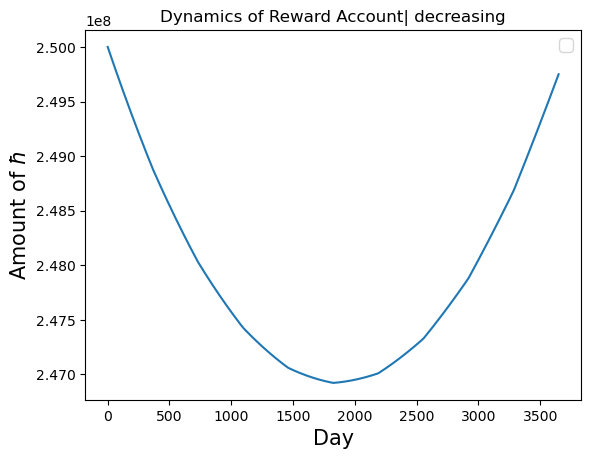

In [53]:
plt.plot(Reward_Account_t)
#plt.yscale('log')
#plt.hlines(1e9/365, 0, 3660)
#plt.vlines(0, 1, 2.6e8, color='0.5', label= '2022-05')


plt.xlabel('Day', fontsize = 15 )# hbar Tx and Token Tx

plt.ylabel('Amount of $\hbar$', fontsize = 15)
plt.legend(fontsize='large')
#plt.suptitle('Dynamics of Reward Account (yearly total reward = 1e9)')

plt.title('Dynamics of Reward Account| decreasing',fontsize = 12)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Dynamics of Reward Account| increasing')

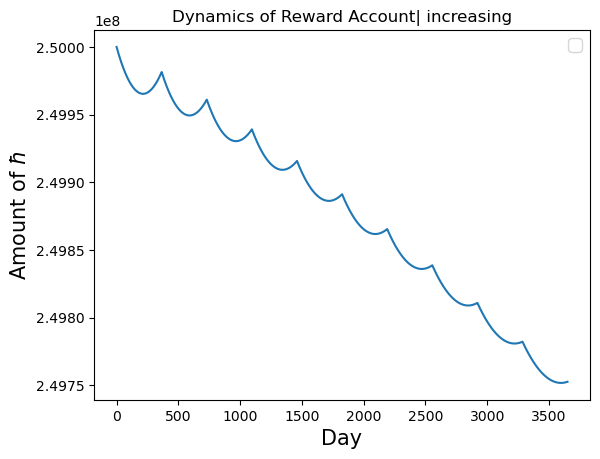

In [56]:
plt.plot(Reward_Account_t)

plt.xlabel('Day', fontsize = 15 )# hbar Tx and Token Tx

plt.ylabel('Amount of $\hbar$', fontsize = 15)
plt.legend(fontsize='large')
#plt.suptitle('Dynamics of Reward Account (yearly total reward = 1e9)')

plt.title('Dynamics of Reward Account| increasing',fontsize = 12)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Dynamics of Reward Account | constant')

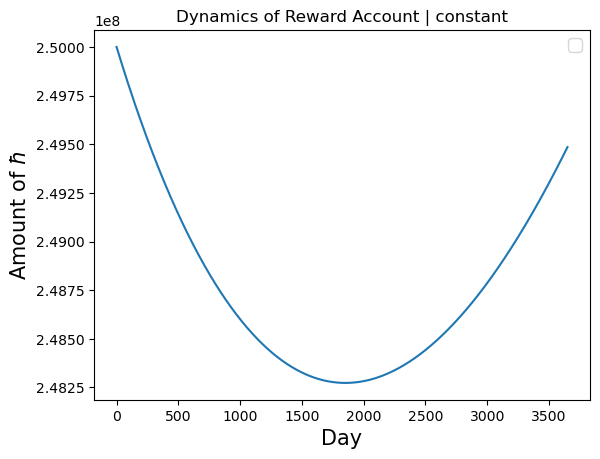

In [59]:
# Constant: FAIL 290 FAIL 664

#plt.figure(figsize=(8,5) ,dpi=200)

plt.plot(Reward_Account_t)
#plt.yscale('log')
#plt.hlines(1e9/365, 0, 3660)
#plt.vlines(0, 1, 2.6e8, color='0.5', label= '2022-05')


plt.xlabel('Day', fontsize = 15 )# hbar Tx and Token Tx

plt.ylabel('Amount of $\hbar$', fontsize = 15)
plt.legend(fontsize='large')
#plt.suptitle('Dynamics of Reward Account (yearly total reward = 1e9)')

plt.title('Dynamics of Reward Account | constant',fontsize = 12)

#plt.savefig('Dynamics of Reward account_D1e6_HT.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'Dynamics of Treasury account (Hbar&Token Tx | $\\alpha$=0.01 | no top-up)')

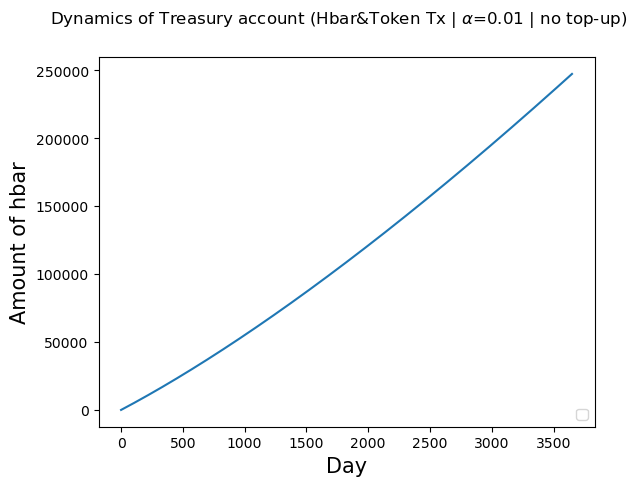

In [61]:

#plt.figure(figsize=(8,5) ,dpi=200)

plt.plot(Treasury_Account_t)

#plt.vlines(0, 1, 1.2e7, color='0.5', label= '2022-05')
plt.xlabel('Day', fontsize = 15)
plt.ylabel('Amount of hbar',fontsize = 15)
plt.legend(loc= 'lower right')
plt.suptitle('Dynamics of Treasury account (Hbar&Token Tx | $\\alpha$=0.01 | no top-up)')

#plt.savefig('Dynamics of Treasury account_alpha001_HT.png')

In [63]:
def Gini(X):
    amount = len(X)
    x_values = X
    Sum=sum(x_values)
    Mean=np.mean(x_values)
    sum_ij=0
    gini=0 
    #Theilt=0
    #Theill=0
    
    for xi in x_values:
        
        #Tti=(xi/Mean)*(np.log(xi/Mean))
        #Tli=np.log(Mean/xi)
        #Theilt+=Tti
        #Theill+=Tli
        for xj in x_values:
            dif=abs(xi-xj)
            sum_ij+=dif
            
    gini=sum_ij / (2 * amount * Sum)
    #Theil_T[T]=Theilt/amount
    #Theil_L[T]=Theill/amount
    return gini  

Text(0.5, 0.98, 'Gini index of wealth')

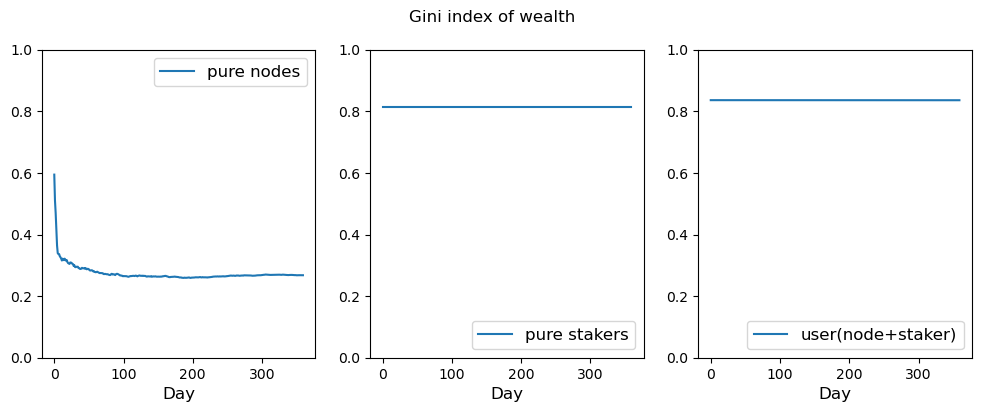

In [65]:
plt.figure(figsize=(12,4),dpi=100)

###Gini_ pure nodes wealth
Gini_nodes_pure=[]
for t in range(0,360*1):

    X_np=list(Pure_nodes_balance_t[t].values())

    gini_t=Gini(X_np)
    Gini_nodes_pure.append(gini_t)

plt.subplot(131)
plt.plot(Gini_nodes_pure, label = 'pure nodes')
plt.ylim(0.0,1)
plt.legend(loc = 'upper right', fontsize = 12)
plt.xlabel('Day', fontsize = 12)

###Gini_stakers wealth
Gini_stakers_pure=[]
for t in range(0,360*1):

    X_sp=list(Pure_stakers_balance_t[t].values())

    gini_t=Gini(X_sp)
    Gini_stakers_pure.append(gini_t)
    
plt.subplot(132)
plt.plot(Gini_stakers_pure, label = 'pure stakers')
plt.ylim(0.0,1)
plt.legend(loc = 'lower right', fontsize = 12)
#plt.yscale('symlog')
plt.xlabel('Day', fontsize = 12)

#Gini_stakers+nodes wealth
Gini_user=[]
for t in range(0,360*1):
    X_u=list(User_Balance_t[t].values())
    
    gini_t=Gini(X_u)
    Gini_user.append(gini_t)
    
plt.subplot(133)
plt.plot(Gini_user, label = 'user(node+staker)')
plt.ylim(0.0,1)
plt.legend(loc='lower right', fontsize = 12)
plt.xlabel('Day',fontsize = 12)

plt.suptitle('Gini index of wealth')

Text(0.5, 1.0, 'Gini index of wealth')

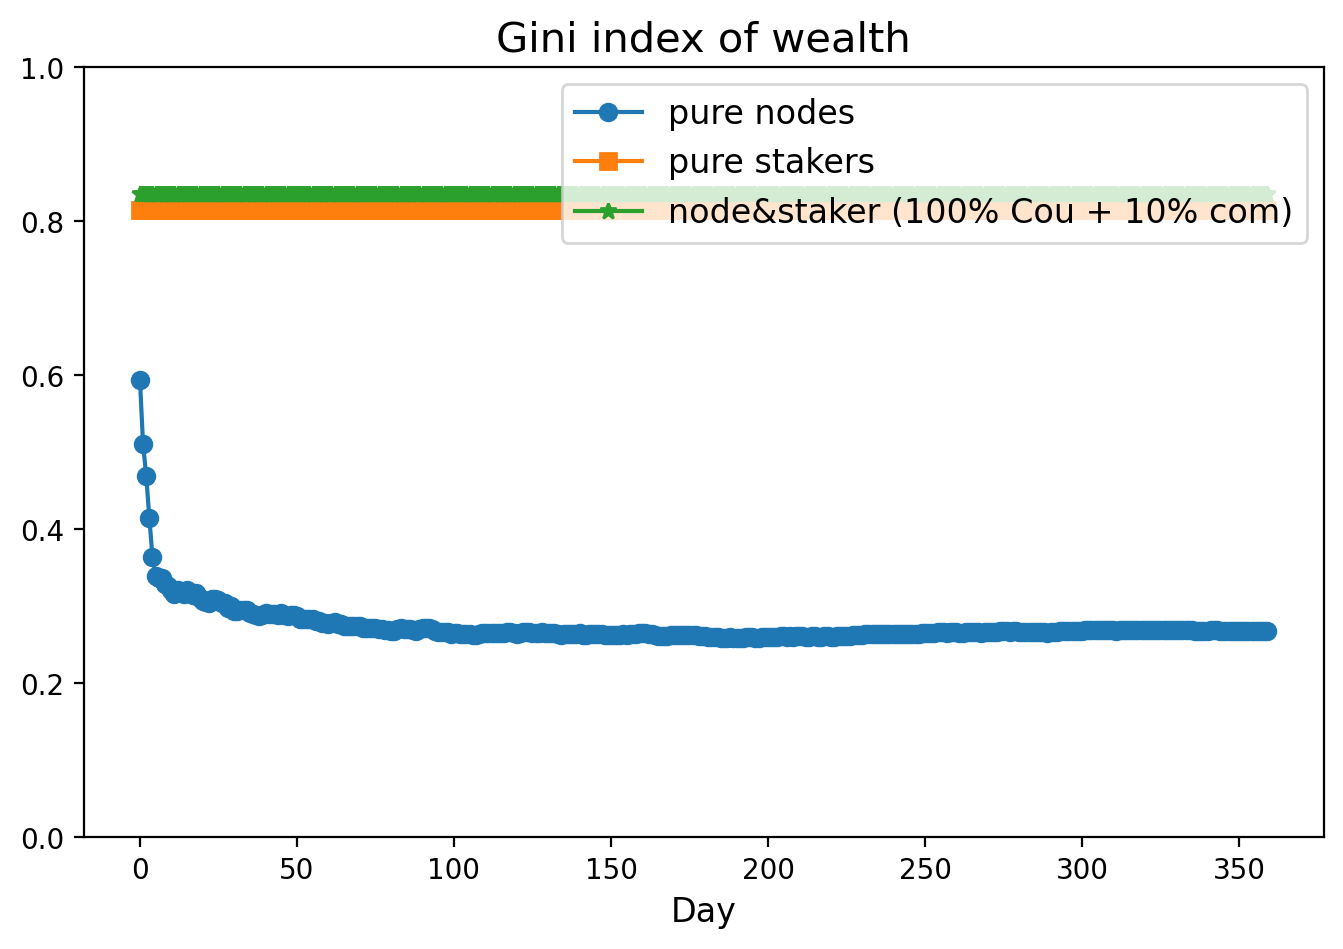

In [66]:
plt.figure(figsize=(8,5),dpi=200)
plt.plot(Gini_nodes_pure, 'o-' ,label = 'pure nodes')
plt.plot(Gini_stakers_pure, 's-' ,label = 'pure stakers' )
plt.plot(Gini_user, '*-' ,label = 'node&staker (100% Cou + 10% com)')


plt.ylim(0.0,1)
plt.legend(loc = 'upper right', fontsize = 12)
plt.xlabel('Day', fontsize = 12)
plt.title('Gini index of wealth', fontsize = 15)

#plt.savefig('Gini_wealth_nodes_stakers_users_allCom.png')

Text(0.5, 1.0, 'Dynamics process of pure nodes balance')

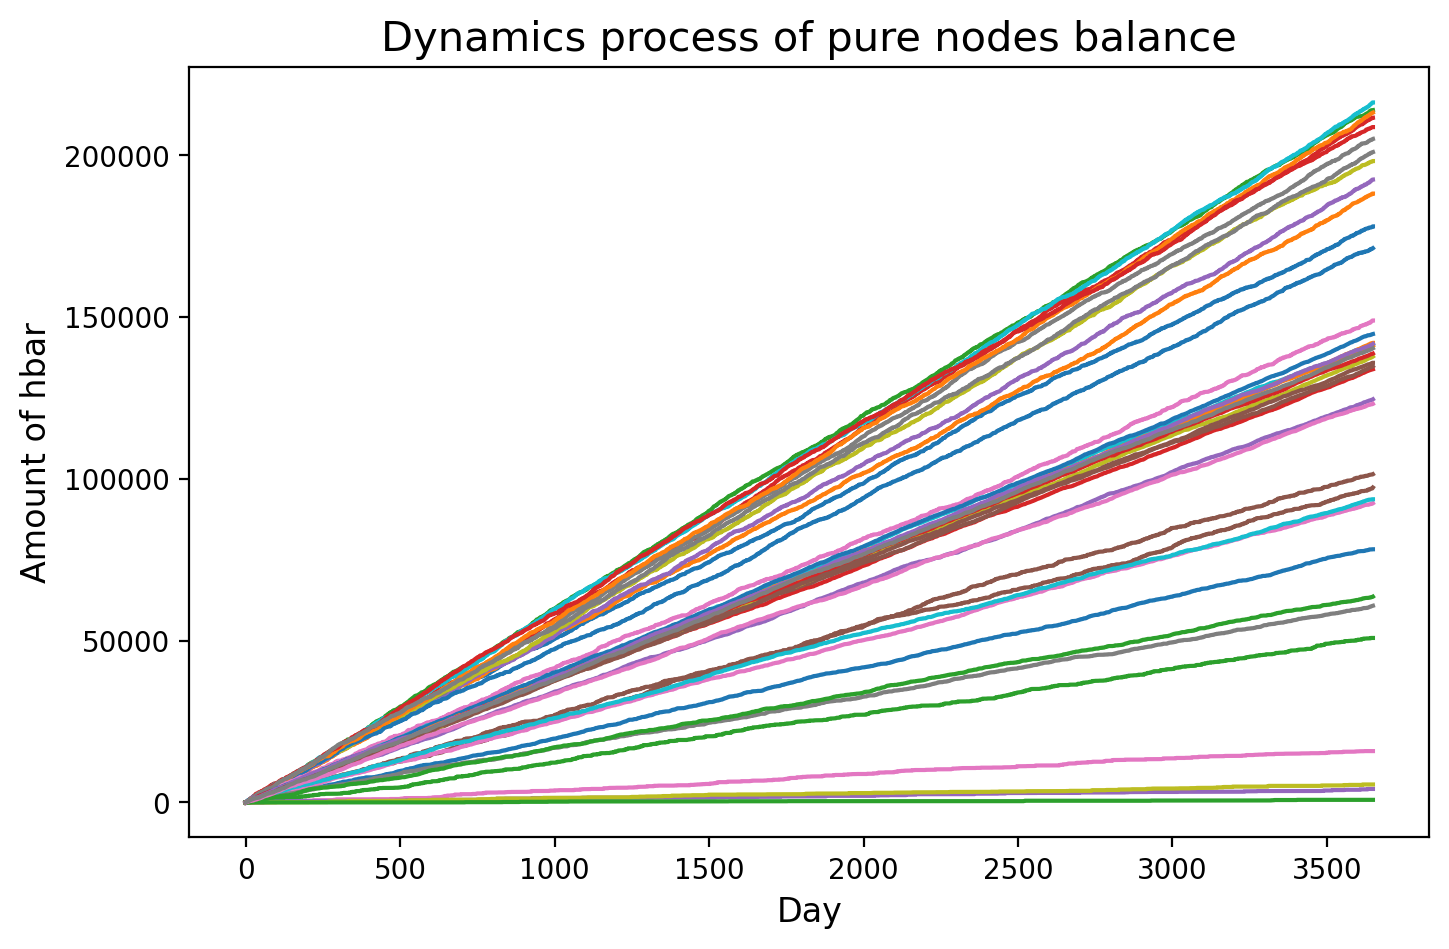

In [67]:


#nodes_initial_balance = T.nodes.balance_nodes_intial

plt.figure(figsize=(8,5) ,dpi=200)

Reward_node={}
for node in Pure_nodes_balance_t[0].keys():
    for t in Pure_nodes_balance_t.keys():
        Reward_node[node]=Reward_node.get(node,[])+[Pure_nodes_balance_t[t][node]]
    plt.plot( Reward_node[node], label=node)
#plt.legend(fontsize='8')
plt.xlabel('Day', fontsize = 12)
plt.ylabel('Amount of hbar', fontsize = 12)
plt.title('Dynamics process of pure nodes balance', fontsize = 15)



#plt.savefig('Dynamics_nodes balance_pure.png')


Text(0.5, 1.0, 'Dynamics of pure stakers cumulative revenue')

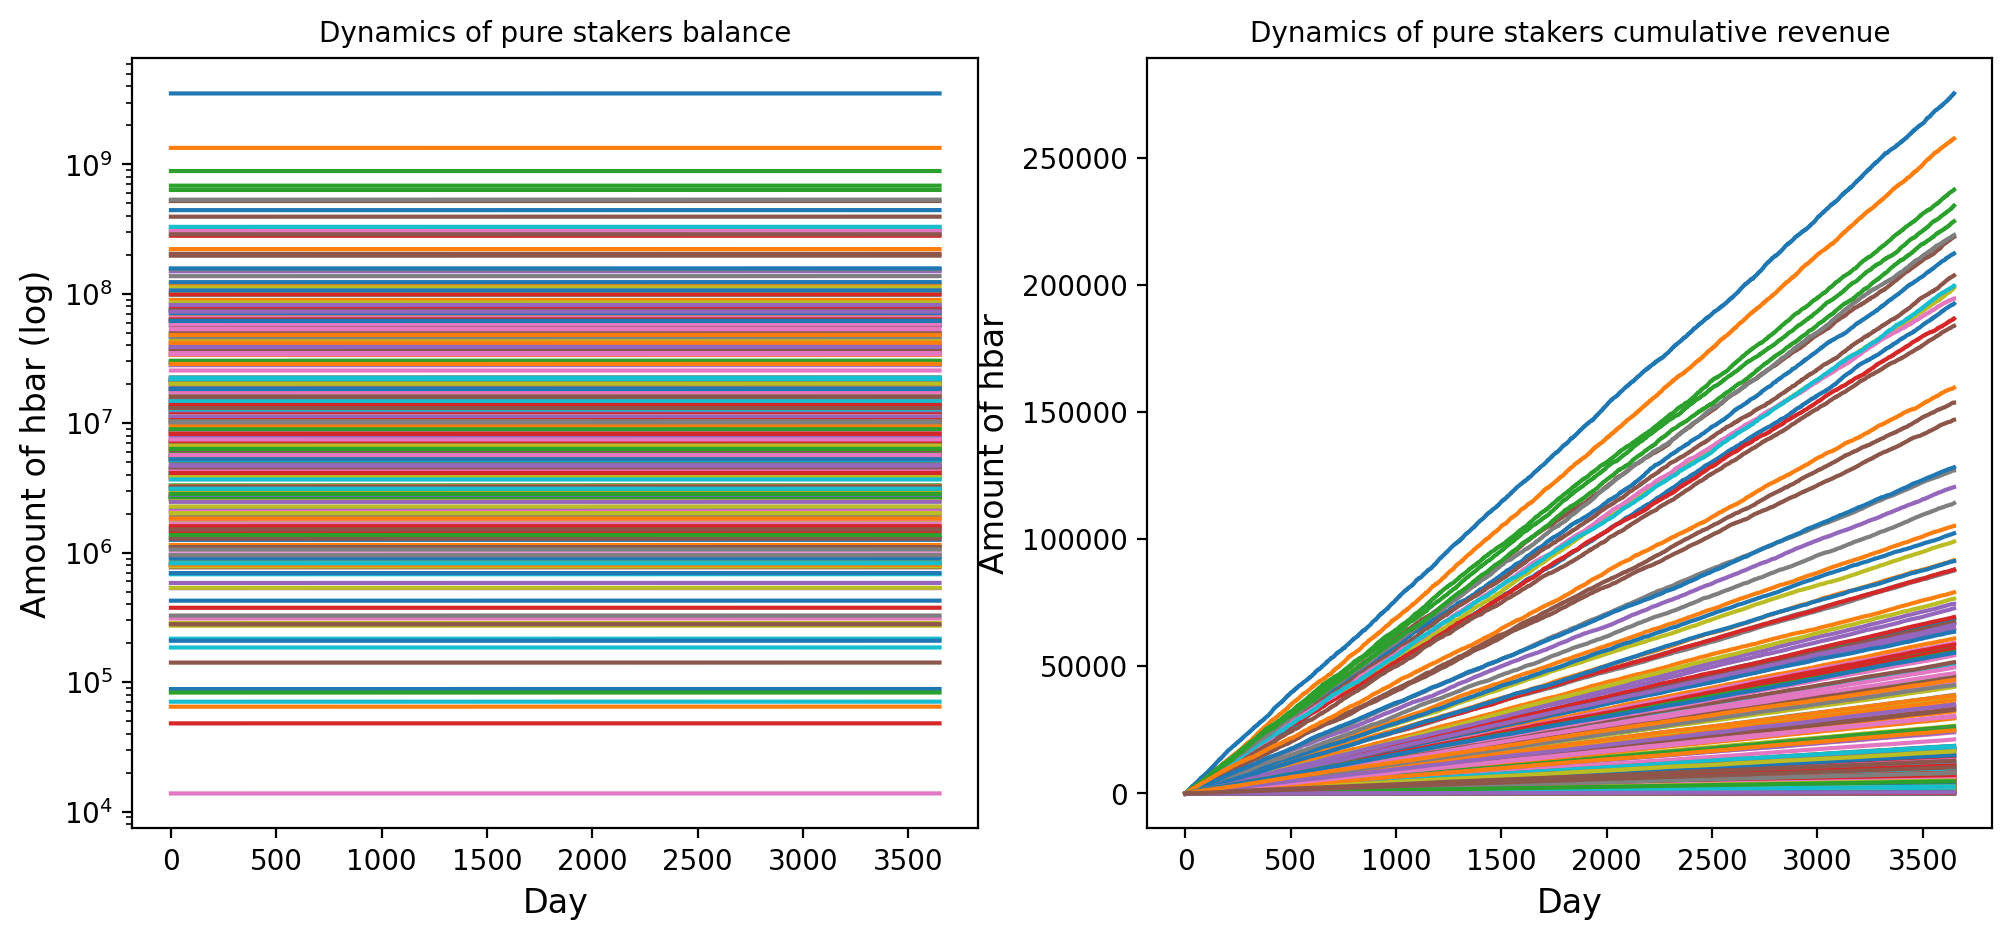

In [68]:

#staker_initial_balance = T.stakers.balance_stakers_intial

plt.figure(figsize=(12,5) ,dpi=200)

plt.subplot(121)
Reward_staker={}
for staker in Pure_stakers_balance_t[0].keys():
    for t in Pure_stakers_balance_t.keys():
        Reward_staker[staker]=Reward_staker.get(staker,[])+[Pure_stakers_balance_t[t][staker]]
    plt.plot(Reward_staker[staker], label=staker)
#plt.legend()
plt.yscale('log')

plt.xlabel('Day', fontsize = 12)
plt.ylabel('Amount of hbar (log)', fontsize = 12)

plt.title('Dynamics of pure stakers balance', fontsize= 10)

plt.subplot(122)
Reward_staker={}
staker_initial_balance = T.stakers.balance_stakers_intial

for staker in Pure_stakers_balance_t[0].keys():
    for t in Pure_stakers_balance_t.keys():
        Reward_staker[staker]=Reward_staker.get(staker,[])+[Stakers_Balance_t[t][staker]]
    plt.plot(Reward_staker[staker]-staker_initial_balance[staker], label=staker)
#plt.legend()
#plt.yscale('log')

plt.xlabel('Day', fontsize = 12)
plt.ylabel('Amount of hbar', fontsize = 12)

plt.title('Dynamics of pure stakers cumulative revenue', fontsize= 10)


#plt.savefig('Dynamics_staker_balance_revenue_pure.png')

Text(0.5, 1.0, 'Dynamics of user cumulative revenue')

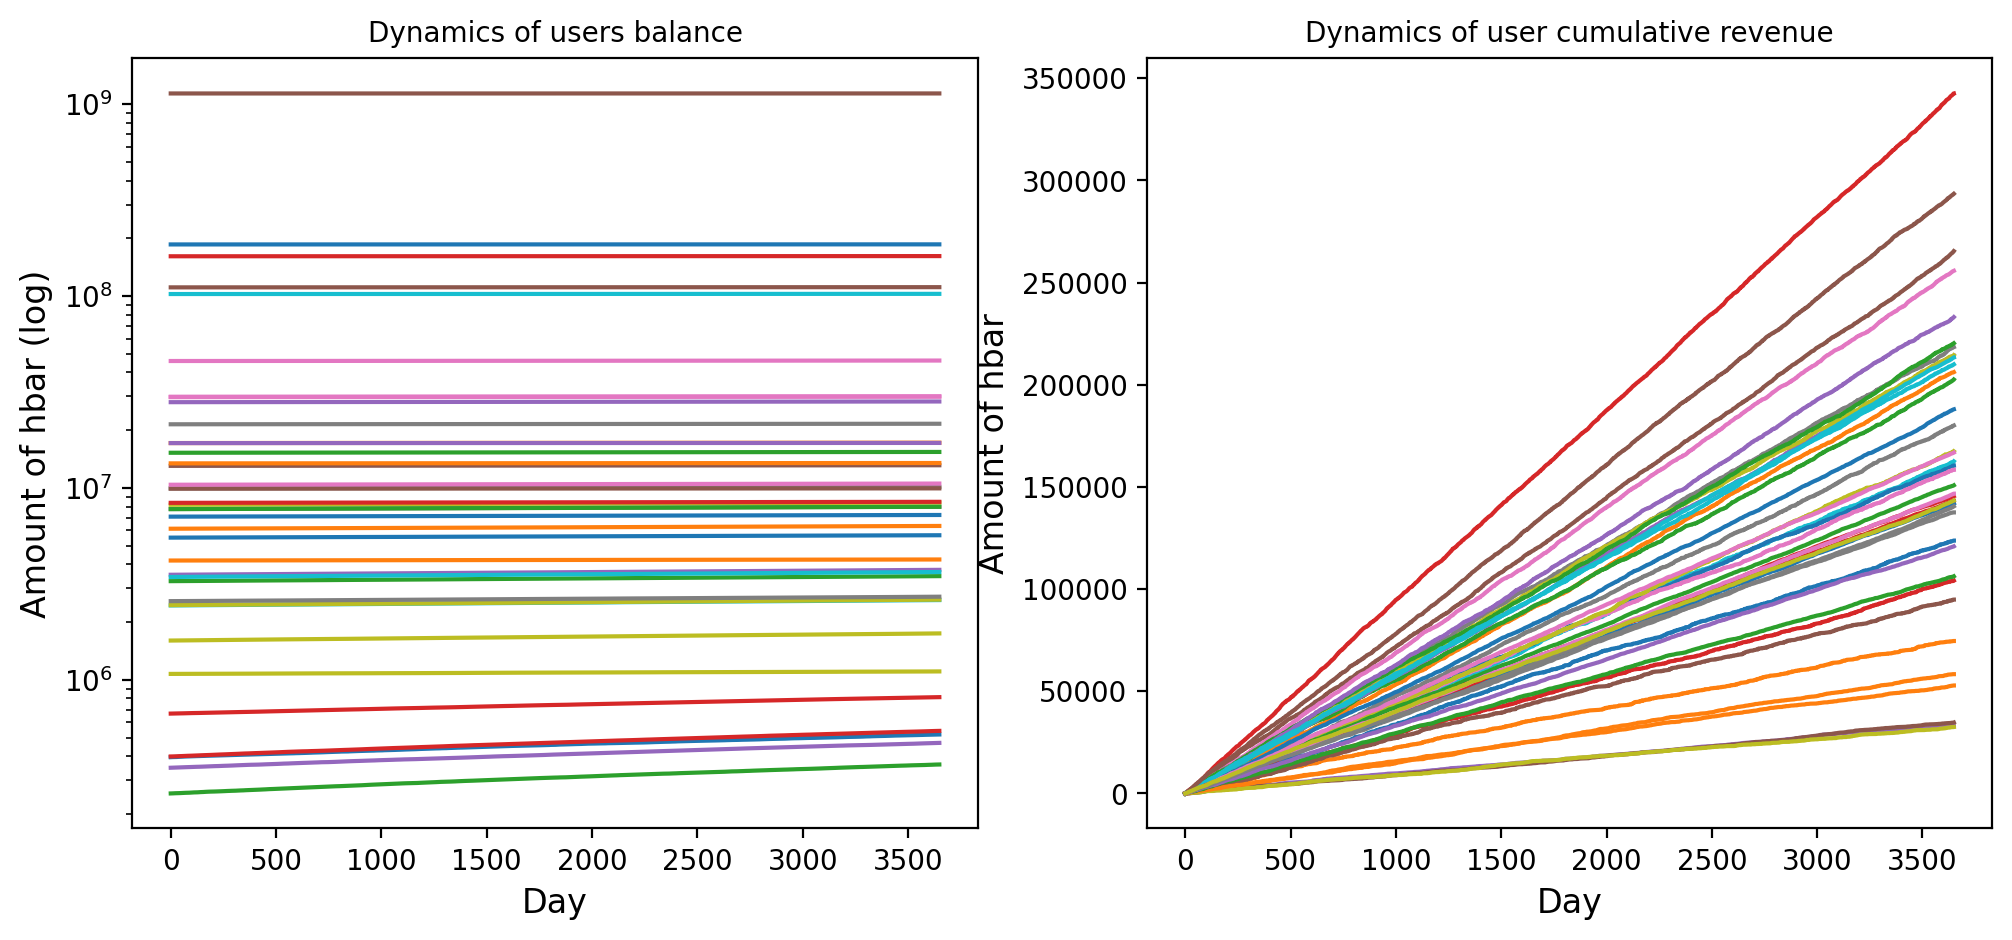

In [69]:

#staker_initial_balance = T.stakers.balance_stakers_intial

plt.figure(figsize=(12,5) ,dpi=200)

plt.subplot(121)
Reward_staker={}
for staker in User_Balance_t[0].keys():
    for t in User_Balance_t.keys():
        Reward_staker[staker]=Reward_staker.get(staker,[])+[User_Balance_t[t][staker]]
    plt.plot(Reward_staker[staker], label=staker)
#plt.legend()
plt.yscale('log')

plt.xlabel('Day', fontsize = 12)
plt.ylabel('Amount of hbar (log)', fontsize = 12)

plt.title('Dynamics of users balance', fontsize= 10)

plt.subplot(122)
Reward_staker={}
staker_initial_balance = T.stakers.balance_stakers_intial

for staker in User_Balance_t[0].keys():
    for t in User_Balance_t.keys():
        Reward_staker[staker]=Reward_staker.get(staker,[])+[User_Balance_t[t][staker]]
    plt.plot(Reward_staker[staker]-staker_initial_balance[staker], label=staker)
#plt.legend()
#plt.yscale('log')

plt.xlabel('Day', fontsize = 12)
plt.ylabel('Amount of hbar', fontsize = 12)

plt.title('Dynamics of user cumulative revenue', fontsize= 10)


#plt.savefig('Dynamics_balance_revenue_user.png')

In [79]:
#nodes_id = [i+10000 for i in range(39+38)]

#threshold_1_3 = math.ceil(T.nodes.N/3)

#threshold_1_3 = 4e9/3
#threshold_1_2 = 4e9/2


Nakamoto_box_year_Stake_In2= []
#Nakamoto_box_year_Stake_In3 = []
for year in range(10):
    Nakamoto =[]    
    for day in range(0+(365*year),365*(year+1)):
        weight_day = list(Nodes_Stake_t[day].values())
        
        weight_sum = sum(weight_day)
        weight_day.sort(reverse=True)

        sum_weight =0
        i=0

        while sum_weight < weight_sum/2:
            sum_weight += weight_day[i]
            i+= 1
        Nakamoto.append(i/77)
    Nakamoto_box_year_Stake_In2.append(Nakamoto)

    
#plt.boxplot(Nakamoto_box_year_Stake_In2)

In [71]:
import matplotlib.patches as mpatches

def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

Text(0.5, 1.0, 'Nakamoto coeficient')

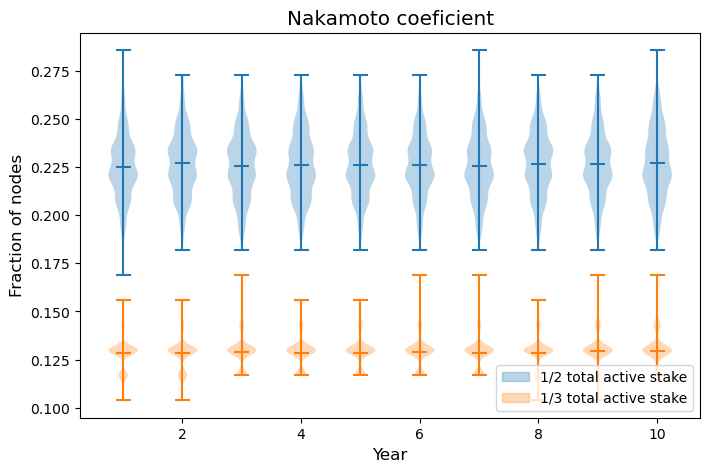

In [78]:
plt.figure(figsize=(8,5) )
labels = []

add_label(plt.violinplot(Nakamoto_box_year_Stake_In2, 
               showmeans=True,
                   showmedians=False), '1/2 total active stake')

add_label(plt.violinplot(Nakamoto_box_year_Stake_In3, 
               showmeans=True,
                   showmedians=False), '1/3 total active stake')

plt.legend(*zip(*labels), loc=4)

plt.xlabel('Year', fontsize = 'large')
plt.ylabel('Fraction of nodes', fontsize = 'large')

plt.title('Nakamoto coeficient', fontsize = 'x-large')

#plt.savefig('./Output_plot/Nakamoto coeficient_stake.png', dpi=200)

Text(0.5, 1.0, 'Voting Weight_before scaling (day 1000|100 00-38: council nodes)')

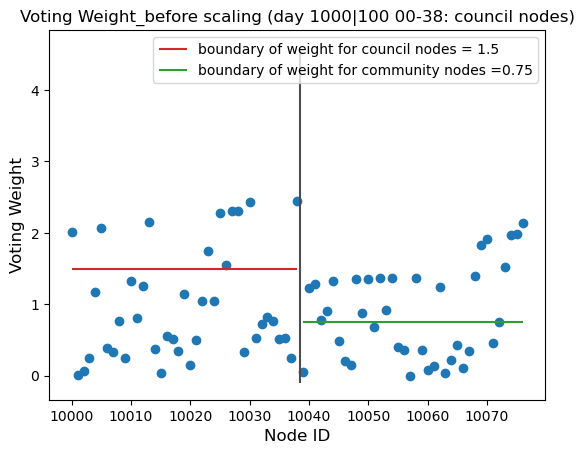

In [75]:
#plt.figure(figsize=(8,5) ,dpi=200)

nodes_id = [i+10000 for i in range(39+38)]
share_day = list(Nodes_voting_share[1000].values())
#share_day.sort(reverse=True)
plt.hlines(1.5,10000,10038, 'tab:red', label = 'boundary of weight for council nodes = 1.5' )
plt.hlines(0.75, 10039, 10076, 'tab:green', label = 'boundary of weight for community nodes =0.75' )
plt.vlines(10038.5, -0.1, 4.6, '0.3')
plt.scatter(nodes_id, share_day )
plt.legend()

plt.xlabel('Node ID',fontsize = 12)
plt.ylabel('Voting Weight', fontsize = 12)
plt.title('Voting Weight_before scaling (day 1000|100 00-38: council nodes)')

#plt.savefig('Plots/Voting weight_before scaling.png')

Text(0.5, 1.0, 'Voting Weight_after scaling (day_1000|100 00-38: council nodes)')

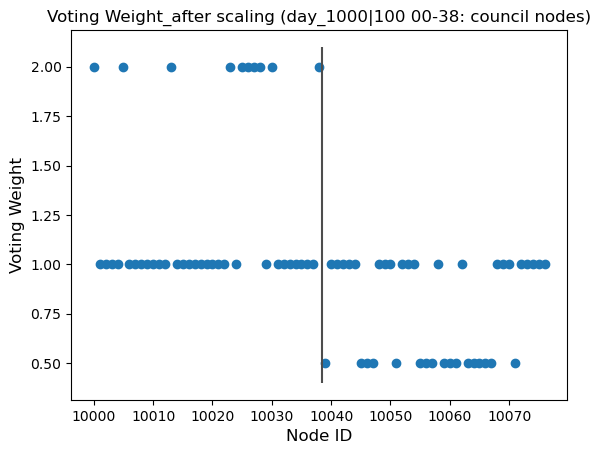

In [74]:
#plt.figure(figsize=(8,5) ,dpi=200)

nodes_id = [i+10000 for i in range(39+38)]
weight_day = list(Nodes_voting_weight[1000].values())
#weight_day.sort(reverse=True)
plt.vlines(10038.5, 0.4, 2.1, '0.3' )
plt.scatter(nodes_id, weight_day )
plt.xlabel('Node ID',fontsize = 12)
plt.ylabel('Voting Weight', fontsize = 12)
plt.title('Voting Weight_after scaling (day_1000|100 00-38: council nodes)')
#plt.legend()

#plt.savefig('Plots/Voting weight_after scaling.png')

In [81]:
threshold_1_3 = T.nodes.N/3
#threshold_1_2 = T.nodes.N/2

Nakamoto_box_year = []
for year in range(10):
    Nakamoto =[]    
    for day in range(0+(360*year),360*(year+1)):
        weight_day = list(Nodes_voting_weight[day].values())
        weight_day.sort(reverse=True)

        sum_weight =0
        i=0

        while sum_weight < threshold_1_3:
            sum_weight += weight_day[i]
            i+= 1
        Nakamoto.append(i/77)
    Nakamoto_box_year.append(Nakamoto)

    
#plt.boxplot(Nakamoto_box_year)

Text(0.5, 1.0, 'Nakamoto coeficient - 1/3 total voting weight')

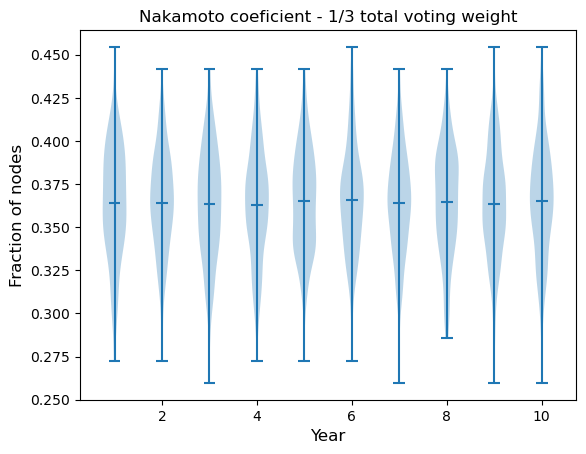

In [84]:
#plt.figure(figsize=(8,5) ,dpi=200)

plt.violinplot(Nakamoto_box_year, 
               showmeans=True,
                   showmedians=False)
plt.xlabel('Year', fontsize = 'large')
plt.ylabel('Fraction of nodes', fontsize = 'large')

plt.title('Nakamoto coeficient - 1/3 total voting weight')
#plt.savefig('Plots/Nakamoto_cou=2com_ratio.png')